## Prepared by Ishaan Arora (ia2419) 
For any doubts drop a line on ia2419@columbia.edu

## The following code is majorly based  on Chris McCormik's BERT research tutorial https://www.youtube.com/watch?v=Hnvb9b7a_Ps&t=161s
## Jay Alamar's blog post (Must check this out) It has beautiful visualizations http://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/


In [0]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In order for torch to use the GPU, we need to identify and specify the GPU as the device. Later, in our training loop, we will load data onto the device. 

In [0]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


## Installing the Hugging Face Library


In [0]:
!pip install transformers

# Load Data from google drive

In [0]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
import pandas as pd

# Load the dataset into a pandas dataframe.
df = pd.read_csv("/gdrive/My Drive/winemag-data-130k-v2.csv", delimiter=',')

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df.shape[0]))

# Display 10 random rows from the data.
df.sample(10)

Number of training sentences: 129,971



,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
70574,70574,Italy,"This opens with a beautiful fragrance of rose,...",Lazzarito Riserva,94,NaN,Piedmont,Barolo,NaN,Kerin O’Keefe,@kerinokeefe,Germano Ettore 2009 Lazzarito Riserva (Barolo),Nebbiolo,Germano Ettore
82947,82947,Italy,"Fresh and easy, with bright acidity and steady...",Brut,87,16.0,Piedmont,Piedmont,NaN,NaN,NaN,Borgo Maragliano NV Brut Chardonnay (Piedmont),Chardonnay,Borgo Maragliano
109603,109603,Italy,This extremely pale rosato doesn't have a very...,Rosato,87,38.0,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Girolamo Russo 2013 Rosato Nerello Mascalese (...,Nerello Mascalese,Girolamo Russo
25752,25752,US,"From a 2,500-foot elevation site, this Cab Fra...",Monarch Mine Vineyard,91,24.0,California,Sierra Foothills,Sierra Foothills,Virginie Boone,@vboone,Easton 2011 Monarch Mine Vineyard Cabernet Fra...,Cabernet Franc,Easton
29938,29938,Portugal,"Ripe with red-berry flavors, this wine is fres...",Tinto,85,18.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta Dona Matilde 2014 Tinto Red (Douro),Portuguese Red,Quinta Dona Matilde
94923,94923,France,"There is considerable freshness here, along wi...",Grande Cuvée,84,NaN,Bordeaux,Bordeaux,NaN,Roger Voss,@vossroger,Château Grand Rolland 2008 Grande Cuvée (Bord...,Bordeaux-style Red Blend,Château Grand Rolland
38551,38551,Italy,When Donatella Colombini left the family estat...,NaN,91,38.0,Tuscany,Brunello di Montalcino,NaN,Roger Voss,@vossroger,Donatella Cinelli Colombini 1997 Brunello di ...,Sangiovese,Donatella Cinelli Colombini
59529,59529,France,"A fine combination of wood and ripe, tropical ...",Pavillon Blanc de Château Margaux,93,NaN,Bordeaux,Bordeaux Blanc,NaN,Roger Voss,@vossroger,Château Margaux 2010 Pavillon Blanc de Château...,Bordeaux-style White Blend,Château Margaux
65890,65890,US,A spray of lemon-lime acidity casts a spotligh...,Semi Dry,88,13.0,New York,Finger Lakes,Finger Lakes,Anna Lee C. Iijima,NaN,Fulkerson 2013 Semi Dry Riesling (Finger Lakes),Riesling,Fulkerson
23454,23454,Spain,"Grassy and pungent, with lime, citrus and whit...",NaN,86,15.0,Northern Spain,Rueda,NaN,Michael Schachner,@wineschach,Mania 2008 Verdejo (Rueda),Verdejo,Mania


In [0]:
df.sample(5)[['description', 'points']]

,description,points
76296,Because it is crafted from old vines from a si...,92
71414,"Dark, oaky and smoky for a value wine, this ha...",89
28451,"Tastes like sugared orange and apricot juice, ...",82
106503,"This is dry, spicy and subdued on the bouquet,...",87
102510,"Coming from 45-year old plantings, this warm-v...",89


### Optional: Bert takes a lot of time to train, if you want to train on the whole dataset, comment out the next line and the code will run just fine without any memory errors

In [0]:
df = df.groupby('points').apply(lambda x: x.sample(frac=0.01))

In [0]:
df.shape

(1298, 14)

### Our estimates show it will take roughly 1 hour to run one epoch on the whole dataset on a tesla GPU provided by Google collab



Let's extract the sentences and labels of our training set as numpy ndarrays.

In [0]:
# Get the lists of sentences and their labels.
sentences = df.description.values
points = df.points.values

## BERT Tokenizer


To feed our text to BERT, it must be split into tokens, and then these tokens must be mapped to their index in the tokenizer vocabulary.

The tokenization must be performed by the tokenizer included with BERT--the below cell will download this for us. We'll be using the "uncased" version here.


In [0]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


Let's apply the tokenizer to one sentence just to see the output.


In [0]:
# Print the original sentence.
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  Smells baked and hot, tastes harsh and dry, a bitter, astringent wine without charm.
Tokenized:  ['smells', 'baked', 'and', 'hot', ',', 'tastes', 'harsh', 'and', 'dry', ',', 'a', 'bitter', ',', 'as', '##tri', '##ngen', '##t', 'wine', 'without', 'charm', '.']
Token IDs:  [14747, 17776, 1998, 2980, 1010, 16958, 8401, 1998, 4318, 1010, 1037, 8618, 1010, 2004, 18886, 25997, 2102, 4511, 2302, 11084, 1012]


When we actually convert all of our sentences, we'll use the `tokenize.encode` function to handle both steps, rather than calling `tokenize` and `convert_tokens_to_ids` separately. 

Before we can do that, though, we need to talk about some of BERT's formatting requirements.

3.2. Required Formatting

The above code left out a few required formatting steps that we'll look at here.

*Side Note: The input format to BERT seems "over-specified" to me... We are required to give it a number of pieces of information which seem redundant, or like they could easily be inferred from the data without us explicity providing it. But it is what it is, and I suspect it will make more sense once I have a deeper understanding of the BERT internals.*

We are required to:
1. Add special tokens to the start and end of each sentence.
2. Pad & truncate all sentences to a single constant length.
3. Explicitly differentiate real tokens from padding tokens with the "attention mask".



### Sentence Length & Attention Mask



## Tokenize Dataset

The transformers library provides a helpful `encode` function which will handle most of the parsing and data prep steps for us.

Before we are ready to encode our text, though, we need to decide on a **maximum sentence length** for padding / truncating to.

The below cell will perform one tokenization pass of the dataset in order to measure the maximum sentence length.

In [0]:
max_len = 0

# For every sentence...
count=0
for sent in sentences:
  count=count+1
  if(count%1000==0):
    print(count," encoded")
  # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
  input_ids = tokenizer.encode(sent, add_special_tokens=True)

  # Update the maximum sentence length.
  max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

1000  encoded
Max sentence length:  127


I'll set the maximum length to 96.


In [0]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
count=0
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    count=count+1
    if(count%1000==0):
      print(count," encoded")
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 96,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(points)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

1000  encoded
Original:  Smells baked and hot, tastes harsh and dry, a bitter, astringent wine without charm.
Token IDs: tensor([  101, 14747, 17776,  1998,  2980,  1010, 16958,  8401,  1998,  4318,
         1010,  1037,  8618,  1010,  2004, 18886, 25997,  2102,  4511,  2302,
        11084,  1012,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0])


In [0]:
labels=labels.float()

 3.4. Training & Validation Split


Divide up our training set to use 90% for training and 10% for validation.

In [0]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

1,168 training samples
  130 validation samples


We'll also create an iterator for our dataset using the torch DataLoader class. This helps save on memory during training because, unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory.

In [0]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

#  Train Our Classification Model

Now that our input data is properly formatted, it's time to fine tune the BERT model. 

In [0]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 1, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [0]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

##  Optimizer & Learning Rate Scheduler

In [0]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-3, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-9 # args.adam_epsilon  - default is 1e-8.
                )


In [0]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 40

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

##  Training Loop

Define a helper function for calculating accuracy.

In [0]:
import numpy as np
from sklearn.metrics import mean_absolute_error

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    #print("preds ",preds[:10])
    #print("labels ",labels[:10])
    return mean_absolute_error(preds, labels)
    # pred_flat = np.argmax(preds, axis=1).flatten()
    # labels_flat = labels.flatten()
    # return np.sum(pred_flat == labels_flat) / len(labels_flat)

Helper function for formatting elapsed times as `hh:mm:ss`


In [0]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


We're ready to kick off the training!

In [0]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_error = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_error += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_error / len(validation_dataloader)
    print("  Mean absolute error: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Mean Absolute Error.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 40 ========
Training...


/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)



  Average training loss: 4150.33
  Training epcoh took: 0:00:21

Running Validation...
  Mean absolute error: 33.02
  Validation Loss: 1099.56
  Validation took: 0:00:01

======== Epoch 2 / 40 ========
Training...

  Average training loss: 256.58
  Training epcoh took: 0:00:22

Running Validation...
  Mean absolute error: 2.83
  Validation Loss: 11.33
  Validation took: 0:00:01

======== Epoch 3 / 40 ========
Training...

  Average training loss: 10.44
  Training epcoh took: 0:00:22

Running Validation...
  Mean absolute error: 2.56
  Validation Loss: 9.60
  Validation took: 0:00:01

======== Epoch 4 / 40 ========
Training...

  Average training loss: 10.63
  Training epcoh took: 0:00:21

Running Validation...
  Mean absolute error: 2.40
  Validation Loss: 8.97
  Validation took: 0:00:01

======== Epoch 5 / 40 ========
Training...

  Average training loss: 10.69
  Training epcoh took: 0:00:21

Running Validation...
  Mean absolute error: 2.56
  Validation Loss: 9.61
  Validation took:

Let's view the summary of the training process.

In [0]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Mean Absolute Error.,Training Time,Validation Time
epoch,,,,,
1,4150.33,1099.56,33.02,0:00:21,0:00:01
2,256.58,11.33,2.83,0:00:22,0:00:01
3,10.44,9.60,2.56,0:00:22,0:00:01
4,10.63,8.97,2.40,0:00:21,0:00:01
5,10.69,9.61,2.56,0:00:21,0:00:01
6,10.60,9.20,2.48,0:00:22,0:00:01
7,10.13,9.11,2.45,0:00:22,0:00:01
8,10.63,9.28,2.50,0:00:22,0:00:01
9,10.93,8.99,2.40,0:00:21,0:00:01


Notice that, while the the training loss is going down with each epoch, the validation loss is increasing! This suggests that we are training our model too long, and it's over-fitting on the training data. 

(For reference, we are using 7,695 training samples and 856 validation samples).

Validation Loss is a more precise measure than accuracy, because with accuracy we don't care about the exact output value, but just which side of a threshold it falls on. 

If we are predicting the correct answer, but with less confidence, then validation loss will catch this, while accuracy will not.

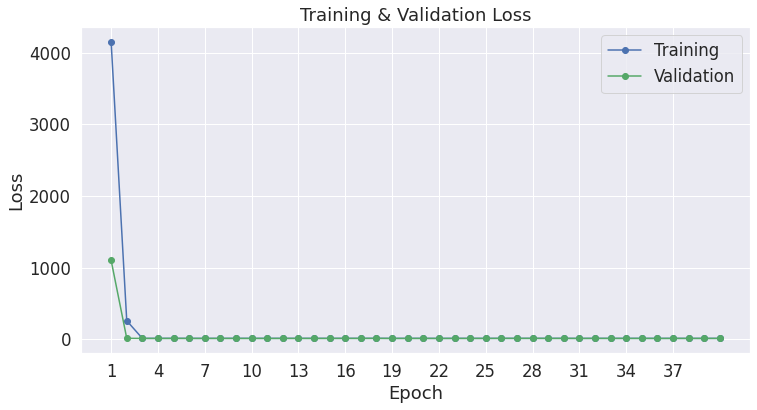

In [0]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks(list(range(1,40,3)))

plt.show()